<a href="https://colab.research.google.com/github/FabianMartinez1234567/Transform-Pokemon-Resolution/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#Ruta raiz
PATH = "/content/drive/MyDrive/ProPoke"
#Ruta de entrada
INPATH= PATH + '/Borrosas'
#Ruta de salida
OUPATH = PATH + '/Normales'
#Check Poins
CKPATH = PATH + "/Generadas"

imgurls = !ls -1 "{INPATH}"

n = 500  #La cantidad de imagenes que voy a utilizar 
train_n = round(n * 0.80)#El porcentaje de images diferentes que voy a tener

#Lista randomizada
randurls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

#Particion train / test

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]
#151 en la carpeta, 121 para entrenar y 30 diferentas
print(len(imgurls), len(tr_urls), len(ts_urls))


898 400 100


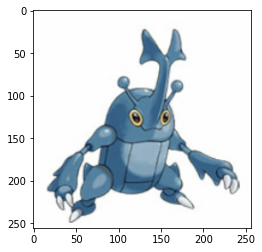

In [3]:
IMG_WIDTH = 256 #Tamaño de las imagenes
IMG_HEIGHT = 256

#Reescalamos las imagenes
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

#Normaliza el rango [-1, +1] la imagen
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

@tf.function()
#Aumentacion de datos: Random Crop + Flip
def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

def load_image(filename, augment=True):

  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)
  return inimg, tgimg

def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

plt.imshow(((load_train_image(randurls[6])[1]) + 1) / 2  ) #Para imprimir


In [9]:
#Zona de Carga de datos
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

#for inimg, tgimg in train_dataset.take(5): #Para probar las imagenes
#  plt.imshow(((tgimg[0,...]) + 1) / 2)
#  plt.show()

test_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)


In [10]:
 from tensorflow.keras import *#nice
 from tensorflow.keras.layers import *

 def downsample(filters, apply_batchnorm = True):

   result = Sequential()

   initializer = tf.random_normal_initializer(0, 0.02)

   #Capa convolucional

   result.add(Conv2D(filters,
                     kernel_size = 4,
                     strides = 2,
                     padding = "same",
                     kernel_initializer = initializer,
                     use_bias =not apply_batchnorm))
   
   if apply_batchnorm:
     #Capa de BatchNorm
     result.add(BatchNormalization())

   #Capa activa
   result.add(LeakyReLU())
   return result
downsample(64) 

In [11]:
def upsample(filters, apply_dropout = False):#Hasta aca todo bien

   result = Sequential()

   initializer = tf.random_normal_initializer(0, 0.02)

   #Capa convolucional

   result.add(Conv2DTranspose(filters, 
                              kernel_size = 4,
                              strides = 2,
                              padding = "same",
                              kernel_initializer = initializer,
                              use_bias=False))
   
   #Capa de BatchNorm
   result.add(BatchNormalization())
   
   if apply_dropout:
     #Capa de Dropout  
     result.add(Dropout(0.5))
     

   #Capa activa
   result.add(ReLU())
   return result
upsample(64) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


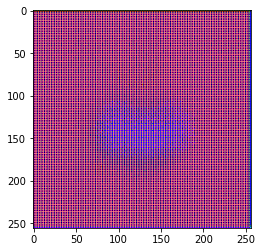

In [12]:
def generator():#Todo lo que esta abajo funciona bien
  
  inputs = tf.keras.layers.Input(shape=[None, None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False),  #(bs , 128, 128, 64)
    downsample(128),                        #(bs , 64, 64, 128)
    downsample(256),                        #(bs , 32, 32, 256)
    downsample(512),                        #(bs , 16, 16, 512)
    downsample(512),                        #(bs , 8, 16, 512)
    downsample(512),                        #(bs , 4, 4, 512)
    downsample(512),                        #(bs , 2, 2, 512)
    downsample(512),                        #(bs , 1, 1, 512)
  ]
  up_stack = [
    upsample(512, apply_dropout=True),      #(bs, 2, 2, 1024)
    upsample(512, apply_dropout=True),      #(bs, 4, 4, 1024)
    upsample(512, apply_dropout=True),      #(bs, 8, 8, 1024)
    upsample(512),                          #(bs, 16, 16, 1024)
    upsample(256),                          #(bs, 32, 32, 512)
    upsample(128),                          #(bs, 64, 64, 256)
    upsample(64),                           #(bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0, 0.02)
  last = Conv2DTranspose(filters=3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")  
  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x, sk])

  last = last(x)

  return Model(inputs = inputs, outputs = last)

generator = generator()
gen_output = generator(((inimg+1)*255),training=False)
plt.imshow(gen_output[0,...])

TensorShape([1, 16, 16, 1])

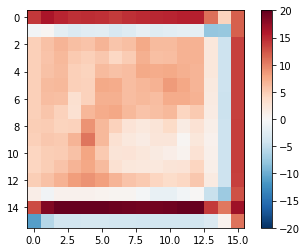

In [14]:
def discriminator():
  ini = Input(shape=[None, None, 3], name = "imput_img")
  gen = Input(shape=[None, None, 3], name = "gener_img")

  con = concatenate([ini, gen])
  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding = "same")(down4)
  return tf.keras.Model(inputs=[ini, gen], outputs=last)
discriminator = discriminator()

disc_out = discriminator([((inimg+1)*255), gen_output], training=False)

plt.imshow(disc_out[0,...,-1],vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

disc_out.shape

In [15]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def descriminator_loss(disc_real_output, disc_generated_output):
  #Diferencia entre los verdaderos y los que detecta el discriminador como falsos

  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  #Diferencia entre los false por se generado y el detectado por el discriminador
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [17]:
LAMBA = 100
#Le pasamos ambas imagenes, la imagen generada y la que queremos tener como resultado
def generator_loss(disc_generated_output,gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
  #mean absolute error :/
  l1_loss=tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBA * l1_loss)
  return total_gen_loss

In [28]:
#Definimos los optimizadores y guardamos los checkpoins
#Guardamos los estados de entrenamientos de la red neuronal(Por si se cae)
import os 

generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Generadas_prefix = os.path.join(CKPATH, ".ckpt")
Generadas = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
Generadas.restore(tf.train.latest_checkpoint(CKPATH))#.assert_consumed()  #Falta el assert_consumed() Pero no se porque tira errores

In [34]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs=True):
  prediction = model(test_input, training = True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/Generadas/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predictec Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      #Getting the pixel values between [0, 1] to plot it
      plt.imshow((display_list[i]* 0.5) + 0.5)#Fijarme porque es medio raro AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
      plt.axis('off')

  plt.show() 

# Nueva sección

In [35]:
@tf.function()
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training = True)

    output_gen_discr = discriminator([output_image, input_image], training = True)

    output_trg_discr = discriminator([target, input_image], training =True)

    discr_loss = descriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)


    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [36]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):

    imgi=0
    for input_image, target in dataset:
      print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait = True)
    imgi=0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi+=1
    #Guardo un checkpoint cada 20 procesos
    if (epoch +1) % 25 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [37]:
train(train_dataset, 100)

epoch 8 - train: 45/400


KeyboardInterrupt: ignored